In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
file = '/content/drive/MyDrive/pet-prediction/pet_adoption_data.csv'

# Exploratory Data Analysis

In [19]:
df = pd.read_csv(file)
df.head()

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,103,Black,Large,16.357608,1,0,43,335,0,0
1,501,Rabbit,Labrador,8,Black,Medium,12.625582,0,0,50,93,0,1
2,502,Dog,Parakeet,153,Gray,Small,9.624407,0,0,3,79,0,0
3,503,Bird,Golden Retriever,91,Gray,Medium,20.770021,0,0,59,37,1,0
4,504,Bird,Golden Retriever,174,Gray,Medium,7.025923,1,0,28,407,0,1


In [20]:
def get_df_info(df):
    print("\nShape of DataFrame:  ", df.shape)
    print("\nColumns in DataFrame: ", df.columns.to_list())
    print("\nData types of columns: \n", df.dtypes)

    print("\nInformation about DataFrame: \n")
    df.info()

    print("\nNumber of unique values in each column: \n")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")

    print("\nNumber of null values in each column: \n", df.isnull().sum())

    print("\nNumber of duplicate rows: \n", df.duplicated().sum())

    print("\nDescriptive statistics of DataFrame: \n", df.describe().transpose())

get_df_info(df)


Shape of DataFrame:   (2007, 13)

Columns in DataFrame:  ['PetID', 'PetType', 'Breed', 'AgeMonths', 'Color', 'Size', 'WeightKg', 'Vaccinated', 'HealthCondition', 'TimeInShelterDays', 'AdoptionFee', 'PreviousOwner', 'AdoptionLikelihood']

Data types of columns: 
 PetID                   int64
PetType                object
Breed                  object
AgeMonths               int64
Color                  object
Size                   object
WeightKg              float64
Vaccinated              int64
HealthCondition         int64
TimeInShelterDays       int64
AdoptionFee             int64
PreviousOwner           int64
AdoptionLikelihood      int64
dtype: object

Information about DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               2007 non-null   int64  
 1   PetType             2007 non-null   objec

## General Distribution Analysis

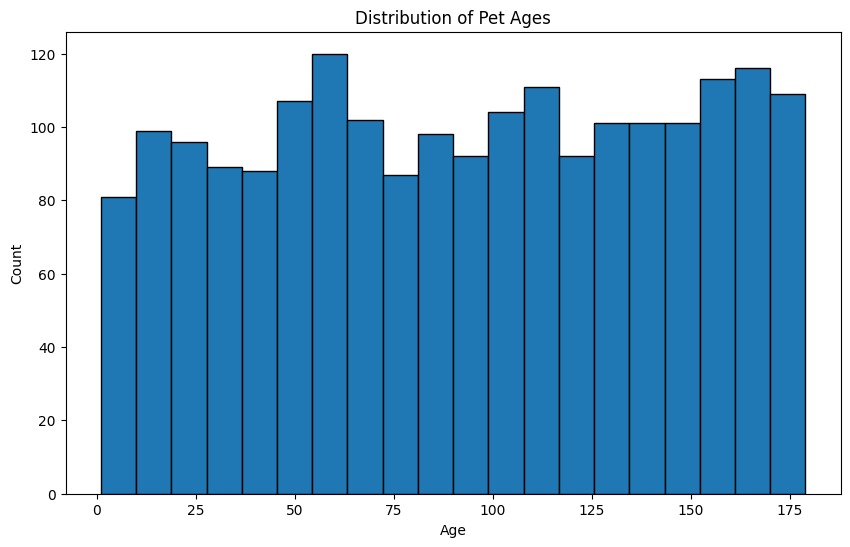

In [25]:
# Distribution of Pet Ages
plt.figure(figsize=(10,6))
plt.hist(df['AgeMonths'], edgecolor='black', bins=20)
plt.title('Distribution of Pet Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

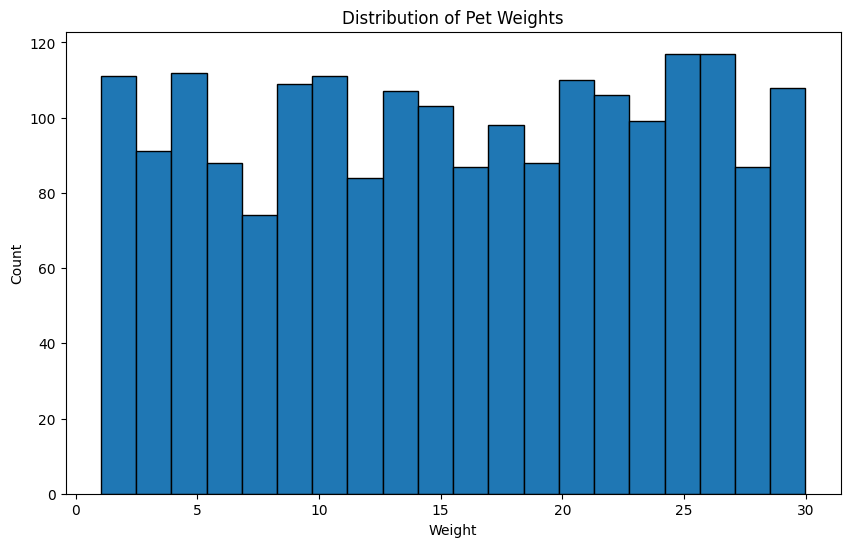

In [26]:
# Distribution of Pet Weights
plt.figure(figsize=(10,6))
plt.hist(df['WeightKg'], edgecolor='black', bins=20)
plt.title('Distribution of Pet Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

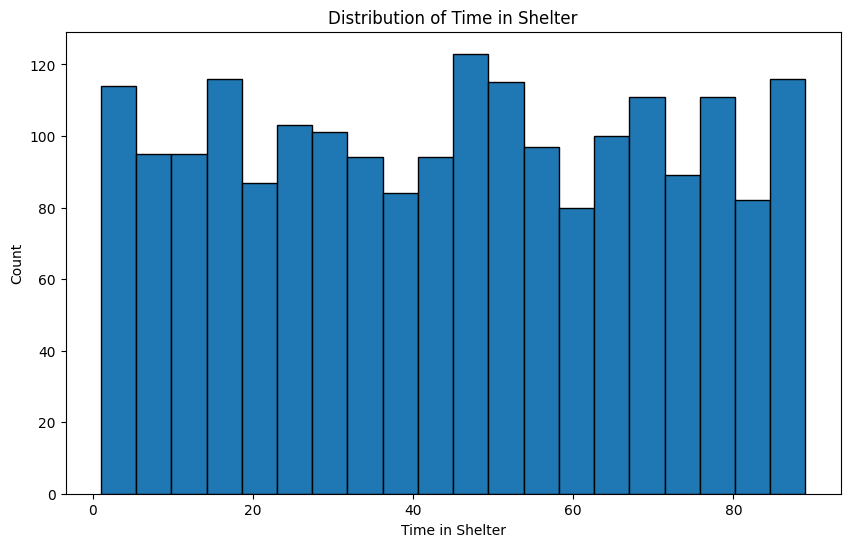

In [28]:
# Distribution of Time in Shelter
plt.figure(figsize=(10, 6))
plt.hist(df['TimeInShelterDays'], edgecolor='black', bins=20)
plt.title('Distribution of Time in Shelter')
plt.xlabel('Time in Shelter')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

In [6]:
# Dropping the 'PetID' column as unique values are not needed to be assessed in the model
df.drop(columns=['PetID'], inplace=True)

In [7]:
# Dividing the dataset into features (X) and target (Y)
X = df.drop(columns=['AdoptionLikelihood'], axis=1)
y = df['AdoptionLikelihood']

In [8]:
# Convert the categorical columns in X to numerical values
X = pd.get_dummies(X)

In [9]:
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (2007, 25)
y shape is (2007,)


# Machine Learning

In [10]:
!pip install scikit-learn

In [11]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.0 MB/s eta 0:00:00


In [12]:
!pip install imblearn

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, StackingClassifier

### The function `apply_models` has several features:

#### Data Preprocessing:

* Splits data into training and testing sets.
* Checks for class imbalance and applies SMOTE (oversampling) if needed.
* Scales the features using StandardScaler.

#### Model Training and Evaluation:

* Defines a set of machine learning classification models.
* Trains each model on the training data.
* Evaluates each model on the testing data using accuracy and F1 score.
* Prints detailed reports (accuracy, confusion matrix, classification report) for each model.

#### Ensemble Learning:

* Identifies the top 3 performing models based on F1 score.
* Creates two ensemble models (Voting Classifier and Stacking Classifier) using the top 3 models.
* Evaluates the ensemble models on the testing data using accuracy, confusion matrix, and classification report.
* In summary, this function is designed to explore various classification models, identify the best performing ones, and potentially improve performance through ensemble learning techniques.

In [14]:
def apply_models(X,y):
  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Check for class imbalance and apply SMOTE (oversampling) if needed
  class_counts = np.bincount(y_train)

  if len(class_counts) > 2 or np.min(class_counts) / np.max(class_counts) < 0.1:
    print('Class imbalance detected. Applying SMOTE...')

  # Applying SMOTE (class imbalance)
  smote = SMOTE(random_state=42)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  # Initialize the StandardScaler
  scaler = StandardScaler()

  # Fit the scaler on the training data and transform both training and test data
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Define the models
  models = {
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'ExtraTrees': ExtraTreesClassifier(),
    'Adaboost': AdaBoostClassifier(),
    'GradientBoost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
  }

  # Initialize a dictionary to hold the performance of each model
  model_performance = {}

  # For each model
  for model_name, model in models.items():
    print(f"**Classification with {model_name}\n{'-'*30}**")

    # Fit model to training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate Accuracy and F1 Score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store performance in performance dictionary
    model_performance[model_name] = (accuracy, f1)

    # Print the Accuracy Score
    print(f'**Accuracy:** {accuracy}')

    # Print the Confusion Matrix
    print(f'**Confusion Matrix:** {confusion_matrix(y_test, y_pred)}')

    # Print the Classification Report
    print(f'**Classification Report:** {classification_report(y_test, y_pred)}')

    print('\n\n\n')

  # Sort the models based on f1 score and pick the top 3
  top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
  print("\nTop 3 Models based on F1 Score:\n", top_3_models)

  # Extract the model names and classifiers for the top 3 models
  top_3_model_names = [model[0] for model in top_3_models]
  top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

  # Create a Voting Classifier with the top 3 models
  print("\n**Initializing Voting Classifier with top 3 models...**\n")
  voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
  voting_clf.fit(X_train, y_train)
  y_pred = voting_clf.predict(X_test)
  print("**Voting Classifier Evaluation**")
  print("\n**Accuracy**:\n", accuracy_score(y_test, y_pred))
  print("\n**Confusion Matrix**:\n", confusion_matrix(y_test, y_pred))
  print("\n**Classification Report**:\n", classification_report(y_test, y_pred))

  # Create a Stacking Classifier with the top 3 models
  print("\n**Initializing Stacking Classifier with top 3 models...**\n")
  stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
  stacking_clf.fit(X_train, y_train)
  y_pred = stacking_clf.predict(X_test)
  print("**Stacking Classifier Evaluation**:")
  print("\n**Accuracy**:\n", accuracy_score(y_test, y_pred))
  print("\n**Confusion Matrix**:\n", confusion_matrix(y_test, y_pred))
  print("\n**Classification Report**:\n", classification_report(y_test, y_pred))

In [15]:
# Apply the function on current dataset
apply_models(X,y)

**Classification with LogisticRegression
------------------------------**
**Accuracy:** 0.9079601990049752
**Confusion Matrix:** [[252   7]
 [ 30 113]]
**Classification Report:**               precision    recall  f1-score   support

           0       0.89      0.97      0.93       259
           1       0.94      0.79      0.86       143

    accuracy                           0.91       402
   macro avg       0.92      0.88      0.90       402
weighted avg       0.91      0.91      0.91       402





**Classification with SVC
------------------------------**
**Accuracy:** 0.9054726368159204
**Confusion Matrix:** [[251   8]
 [ 30 113]]
**Classification Report:**               precision    recall  f1-score   support

           0       0.89      0.97      0.93       259
           1       0.93      0.79      0.86       143

    accuracy                           0.91       402
   macro avg       0.91      0.88      0.89       402
weighted avg       0.91      0.91      0.90       402
